# Import modules
Run 1st.

In [2]:
from __future__ import print_function
from __future__ import division

import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from matplotlib import rc
import copy
import time
import skimage
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
import torch.utils.model_zoo as model_zoo
import torchvision
from torchvision import transforms, datasets, models
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

np.random.seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

PyTorch Version:  1.0.1.post2
Torchvision Version:  0.2.2


# Train function
All learning wrapper calls this training function, because for each caller, we have specified parameters and obejcts to be passed in.

In [37]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, length, scheduler, is_inception=False):
    since = time.time()
    
    train_loss_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    # best_acc = 0.0
    best_loss = float("inf")

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            # running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        # print(outputs)
                        loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                # running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / length[phase]
            # epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            # print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print('{} Loss: {:.4f}'.format(phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_loss = epoch_loss
                val_loss_history.append(val_loss)
            if phase == 'train':
                train_loss_history.append(epoch_loss)
        
        # if it's ReduceLROnPlateau, then need val_loss in the parenthesis
        scheduler.step(val_loss)
        # if it's StepLR, then don't need val_loss in the parenthesis
        # scheduler.step()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_loss_history, train_loss_history

# Models: defining and training

## modified AlexNet by Paper (kddTC)

### kddTC: model

In [4]:
'''
Notice data fed to kddTC should follow the pre-processing steps by the paper
Especially, (1) only two channels should be included;
(2) middle cropping;
(3) rotation?
'''
class kddAlex(nn.Module):

    def __init__(self, num_outputs = 1):
        super(kddAlex, self).__init__()
        ###
        ### Changed 3 to 2 to fit our data dimension sieze
        ###
        self.features = nn.Sequential(
            # nn.Conv2d(2, 64, kernel_size=11, stride=4, padding=2),
            # nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(2, 16, kernel_size=4, stride=2),
            nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=3, stride=2),
        )
        # self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            # nn.Dropout(),
            nn.Linear(128 * 3 * 3, 256),
            nn.ReLU(inplace=True),
            # nn.Dropout(),
            nn.Linear(256, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, num_outputs),
        )

    def forward(self, x):
        x = self.features(x)
        # x = self.avgpool(x)
        x = x.view(x.size(0), 128 * 3 * 3)
        x = self.classifier(x)
        return x


def kddTC(pretrained=False, progress=True, **kwargs):
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = kddAlex(**kwargs)
    # if pretrained:
    #    state_dict = load_state_dict_from_url(model_urls['alexnet'],
    #                                          progress=progress)
    #    model.load_state_dict(state_dict)
    return model


### kddTCData: Dataset object
+ 2 channels;
+ middle crop 64
+ nan and extreme large treatment to 0

In [8]:
class kddTCData(data.Dataset):

    def __init__(self, file_path, transform=None):
        super(kddTCData, self).__init__()
        h5_file = h5py.File(file_path)
        self.data = h5_file.get('matrix')
        # hard code the Vmax label
        self.target = h5_file.get('info/block0_values')[:,2]
        self.transform = transform

    def __getitem__(self, index):
        # middle crop and permute axis
        # we found that in the later cell, there is a "center crop" transform
        # if the transforms.centercrop() works, then no need for 68:(68+64)
        datMatrix = torch.from_numpy(self.data[index, 68:(68+64), 68:(68+64), [0,3]]).permute(2, 0, 1).float()
        # [0,3]
        # datMatrix = (datMatrix - datMatrix.mean(axis=0)) / datMatrix.std(axis=0)
        labMatrix = torch.from_numpy(self.target)[index].float()
        # replace nan with 0
        datMatrix = np.nan_to_num(datMatrix)
        # replace extremely large values with 0
        datMatrix[datMatrix > 1000] = 0
        return (datMatrix, labMatrix)

    def __len__(self):
        return self.data.shape[0]
    
    def length(self):
        return self.data.shape[0]

### kddTClearn: wrapper function that loads data and calls training

In [38]:
def kddTClearn(model, data_source, batch_size, num_epochs, num_data):
    dataDic = {
        '2017': 'TCIR-ALL_2017.h5',
        'c-i-sh': 'TCIR-CPAC_IO_SH.h5',
        'a-e-w':'TCIR-ATLN_EPAC_WPAC.h5'
    }
    transf = {
        'mean': (2.66518896e+02, 2.34601769e+02, 1.80660180e-01, 4.49401281e-01),
        'std': (37.01598561, 24.43164985,  0.43344222,  1.42182753)
    }
    data_transform = transforms.Compose([
        transforms.Normalize(mean=transf['mean'], std=transf['std']) 
        # transforms.CenterCrop(64)
    ])
    data = kddTCData(dataDic[data_source],
                         transform = data_transform)
    
    NUM_DATA =  num_data# data.length()
    print(NUM_DATA)
    length = {}
    length['train'] = int(NUM_DATA * 0.7)
    length['val'] = NUM_DATA - int(NUM_DATA * 0.7)
    dataloaders = {}
    dataloaders['train'] = DataLoader(data, batch_size=batch_size, 
                                      sampler=SubsetRandomSampler(range(int(NUM_DATA * 0.7))),
                             num_workers=4)
    dataloaders['val'] = DataLoader(data, batch_size=batch_size, 
                                    sampler=SubsetRandomSampler(range(int(NUM_DATA * 0.7), NUM_DATA)),
                            num_workers=4)
    
    model = model.to(device)

    criterion = nn.MSELoss()

    # Observe that all parameters are being optimized
    # optim.SGD(kdd18.parameters(), lr=0.001, momentum=0.9)

    model_optmzer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.00001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(model_optmzer, 'min', patience = 5, threshold = 0.01, factor = 1/10, threshold_mode  = 'rel')
    # scheduler = optim.lr_scheduler.StepLR(model_optmzer, 20, gamma=0.1, last_epoch=-1)

    model, val_loss_history, train_loss_history = train_model(model, dataloaders, criterion, 
                           model_optmzer, num_epochs=num_epochs, length = length, scheduler = scheduler)
    return model, val_loss_history, train_loss_history

### kdd18: the model created and to be learned

In [39]:
kdd18 = kddTC(pretrained=False)
_, val_loss, train_loss = kddTClearn(kdd18, 'c-i-sh', batch_size = 128, num_epochs = 100, num_data = 500)

500
Epoch 0/99
----------
train Loss: 5097.6123
val Loss: 530.0885

Epoch 1/99
----------
train Loss: 4749.6067
val Loss: 378.8148

Epoch 2/99
----------
train Loss: 4369.6031
val Loss: 217.6769

Epoch 3/99
----------
train Loss: 3895.7184
val Loss: 70.2287

Epoch 4/99
----------
train Loss: 3268.6884
val Loss: 47.7089

Epoch 5/99
----------
train Loss: 2581.4032
val Loss: 433.0974

Epoch 6/99
----------
train Loss: 2146.1040
val Loss: 1611.5635

Epoch 7/99
----------
train Loss: 2246.8295
val Loss: 2638.2253

Epoch 8/99
----------
train Loss: 2368.3095
val Loss: 2124.7544

Epoch 9/99
----------
train Loss: 2178.2284
val Loss: 1310.9010

Epoch 10/99
----------
train Loss: 2086.7635
val Loss: 802.5747

Epoch 11/99
----------
train Loss: 2093.1126
val Loss: 784.3753

Epoch 12/99
----------
train Loss: 2100.5835
val Loss: 777.8417

Epoch 13/99
----------
train Loss: 2099.7027
val Loss: 788.0764

Epoch 14/99
----------
train Loss: 2099.4235
val Loss: 804.8131

Epoch 15/99
----------
train 

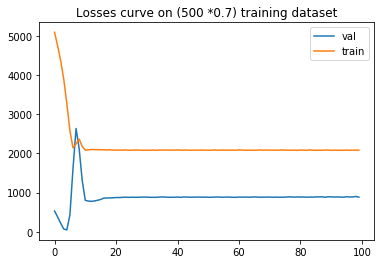

In [40]:
plt.plot(val_loss, label = 'val')
plt.plot(train_loss, label = 'train')
plt.title('Losses curve on (500 *0.7) training dataset')
plt.legend()
plt.show()

In [41]:
kdd18 = kddTC(pretrained=False)
_, val_loss, train_loss = kddTClearn(kdd18, 'c-i-sh', batch_size = 128, num_epochs = 200, num_data = 150)

150
Epoch 0/199
----------
train Loss: 590.6915
val Loss: 7459.6812

Epoch 1/199
----------
train Loss: 574.3341
val Loss: 7407.0205

Epoch 2/199
----------
train Loss: 556.7596
val Loss: 7352.3423

Epoch 3/199
----------
train Loss: 538.6547
val Loss: 7293.3940

Epoch 4/199
----------
train Loss: 519.5234
val Loss: 7229.7476

Epoch 5/199
----------
train Loss: 498.9940
val Loss: 7159.8296

Epoch 6/199
----------
train Loss: 476.7875
val Loss: 7079.1099

Epoch 7/199
----------
train Loss: 451.7263
val Loss: 6986.9229

Epoch 8/199
----------
train Loss: 423.7277
val Loss: 6881.1440

Epoch 9/199
----------
train Loss: 392.5061
val Loss: 6760.7422

Epoch 10/199
----------
train Loss: 358.1120
val Loss: 6625.2393

Epoch 11/199
----------
train Loss: 320.8493
val Loss: 6473.1772

Epoch 12/199
----------
train Loss: 281.1684
val Loss: 6305.5776

Epoch 13/199
----------
train Loss: 239.8636
val Loss: 6120.8892

Epoch 14/199
----------
train Loss: 197.4538
val Loss: 5915.7944

Epoch 15/199
---

train Loss: 9.3517
val Loss: 4417.3481

Epoch 128/199
----------
train Loss: 9.3514
val Loss: 4417.3604

Epoch 129/199
----------
train Loss: 9.3511
val Loss: 4417.3726

Epoch 130/199
----------
train Loss: 9.3509
val Loss: 4417.3848

Epoch 131/199
----------
train Loss: 9.3506
val Loss: 4417.3970

Epoch 132/199
----------
train Loss: 9.3503
val Loss: 4417.4092

Epoch 133/199
----------
train Loss: 9.3500
val Loss: 4417.4214

Epoch 134/199
----------
train Loss: 9.3498
val Loss: 4417.4336

Epoch 135/199
----------
train Loss: 9.3495
val Loss: 4417.4463

Epoch 136/199
----------
train Loss: 9.3492
val Loss: 4417.4585

Epoch 137/199
----------
train Loss: 9.3489
val Loss: 4417.4707

Epoch 138/199
----------
train Loss: 9.3487
val Loss: 4417.4834

Epoch 139/199
----------
train Loss: 9.3484
val Loss: 4417.4956

Epoch 140/199
----------
train Loss: 9.3481
val Loss: 4417.5083

Epoch 141/199
----------
train Loss: 9.3478
val Loss: 4417.5205

Epoch 142/199
----------
train Loss: 9.3476
val Lo

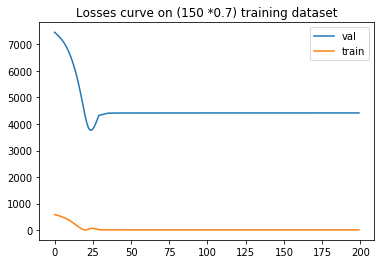

In [43]:
plt.plot(val_loss, label = 'val')
plt.plot(train_loss, label = 'train')
plt.title('Losses curve on (150 *0.7) training dataset')
plt.legend()
plt.show()

## ResNet

### Resnet models

In [2]:
# __all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
#            'resnet152']


# model_urls = {
#     'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
#     'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
#     'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
#     'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
#     'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
# }


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(ResNet, self).__init__()
        ###
        ### change 3 to 2 for our data
        ###
        self.conv1 = nn.Conv2d(2, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model



def resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet34']))
    return model



def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
    return model



def resnet101(pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet101']))
    return model



def resnet152(pretrained=False, **kwargs):
    """Constructs a ResNet-152 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet152']))
    return model

### resnetTCData: Dataset object

In [ ]:
class resnetTCData(data.Dataset):

    def __init__(self, file_path, transform=None):
        super(resnetTCData, self).__init__()
        h5_file = h5py.File(file_path)
        self.data = h5_file.get('matrix')
        # hard code the Vmax label
        self.target = h5_file.get('info/block0_values')[:,2]
        self.transform = transform

    def __getitem__(self, index):
        # middle crop and permute axis
        datMatrix = torch.from_numpy(self.data[index, :, :, [0,3]]).permute(2, 0, 1).float()
        # [0,3]
        # datMatrix = (datMatrix - datMatrix.mean(axis=0)) / datMatrix.std(axis=0)
        labMatrix = torch.from_numpy(self.target)[index].float()
        # replace nan with 0
        datMatrix = np.nan_to_num(datMatrix)
        # replace extremely large values with 0
        datMatrix[datMatrix > 1000] = 0
        return (datMatrix, labMatrix)

    def __len__(self):
        return self.data.shape[0]
    
    def length(self):
        return self.data.shape[0]

### resnetTClearn: wrapper that loads and calls training

In [ ]:
def rensetTClearn(model, data_source, batch_size, num_epochs):
    dataDic = {
        '2017': 'TCIR-ALL_2017.h5',
        'c-i-sh': 'TCIR-CPAC_IO_SH.h5',
        'a-e-w':'TCIR-ATLN_EPAC_WPAC.h5'
    }
    transf = {
        '2017': {'mean': None, 'std': None},
        'c-i-sh': {'mean': None, 'std': None}, 
        'a-e-w': {'mean': None, 'std': None}
    }
    data_transform = transforms.Normalize(mean=transf[data_source]['mean'], std=transf[data_source]['std'])
    data = resnetTCData(dataDic[data_source],
                         transform = data_transform)
    
    NUM_DATA = 10 # data.length()
    print(NUM_DATA)
    length = {}
    length['train'] = int(NUM_DATA * 0.7)
    length['val'] = NUM_DATA - int(NUM_DATA * 0.7)
    dataloaders = {}
    dataloaders['train'] = DataLoader(data, batch_size=batch_size, 
                                      sampler=SubsetRandomSampler(range(int(NUM_DATA * 0.7))))
    dataloaders['val'] = DataLoader(data, batch_size=batch_size, 
                                    sampler=SubsetRandomSampler(range(int(NUM_DATA * 0.7), NUM_DATA)))
    
    
    num_ftrs = model.fc.in_features
    num_output = 1
    model.fc = nn.Linear(num_ftrs, num_output)

    model = model.to(device)

    criterion = nn.MSELoss()

    # Observe that all parameters are being optimized
    # optim.SGD(kdd18.parameters(), lr=0.001, momentum=0.9)
    model_optmzer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.00001)

    model, val_loss_history, train_loss_history = train_model(model, dataloaders, criterion, 
                           model_optmzer, num_epochs=num_epochs, length = length)
    return model, val_loss_history, train_loss_history

### resnet50TC and resnet34TC: overfitting example

In [19]:
resnet50TC = resnet50(pretrained=False)
_, val_loss, train_loss = rensetTClearn(resnet50TC, 'c-i-sh', batch_size = 128, num_epochs = 100)

10
Epoch 0/99
----------
train Loss: 657.2467
val Loss: 12498.6523

Epoch 1/99
----------
train Loss: 636.6534
val Loss: 1912.8895

Epoch 2/99
----------
train Loss: 618.5876
val Loss: 824.0681

Epoch 3/99
----------
train Loss: 599.3378
val Loss: 565.8723

Epoch 4/99
----------
train Loss: 579.7789
val Loss: 483.2373

Epoch 5/99
----------
train Loss: 558.6892
val Loss: 453.1857

Epoch 6/99
----------
train Loss: 536.7385
val Loss: 446.2036

Epoch 7/99
----------
train Loss: 514.2415
val Loss: 455.9376

Epoch 8/99
----------
train Loss: 491.1043
val Loss: 473.7440

Epoch 9/99
----------
train Loss: 467.1476
val Loss: 496.0459

Epoch 10/99
----------
train Loss: 443.1924
val Loss: 519.9662

Epoch 11/99
----------
train Loss: 418.4901
val Loss: 535.3739

Epoch 12/99
----------
train Loss: 394.8045
val Loss: 538.0236

Epoch 13/99
----------
train Loss: 371.4470
val Loss: 536.0168

Epoch 14/99
----------
train Loss: 349.3843
val Loss: 529.3821

Epoch 15/99
----------
train Loss: 328.3347


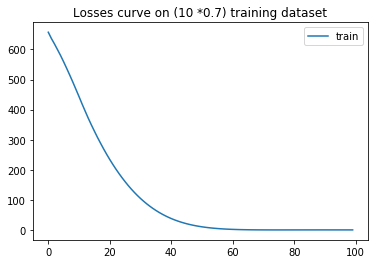

In [20]:
plt.plot(train_loss, label = 'train')
plt.title('Losses curve on (10 *0.7) training dataset')
plt.legend()
plt.show()

In [16]:
resnet34TC = resnet34(pretrained=False)
_, val_loss, train_loss = rensetTClearn(resnet34TC, 'c-i-sh', batch_size = 128, num_epochs = 100)

10
Epoch 0/99
----------
train Loss: 616.3976
val Loss: 48397.8789

Epoch 1/99
----------
train Loss: 582.5171
val Loss: 10609.5586

Epoch 2/99
----------
train Loss: 550.5452
val Loss: 3398.2874

Epoch 3/99
----------
train Loss: 522.2950
val Loss: 1266.1975

Epoch 4/99
----------
train Loss: 495.6078
val Loss: 508.4494

Epoch 5/99
----------
train Loss: 472.3868
val Loss: 197.3113

Epoch 6/99
----------
train Loss: 451.1628
val Loss: 59.9967

Epoch 7/99
----------
train Loss: 432.3529
val Loss: 8.8070

Epoch 8/99
----------
train Loss: 415.2444
val Loss: 3.6894

Epoch 9/99
----------
train Loss: 399.7489
val Loss: 29.8364

Epoch 10/99
----------
train Loss: 385.6147
val Loss: 75.2636

Epoch 11/99
----------
train Loss: 372.4400
val Loss: 129.5394

Epoch 12/99
----------
train Loss: 360.2335
val Loss: 188.1108

Epoch 13/99
----------
train Loss: 348.9835
val Loss: 242.2749

Epoch 14/99
----------
train Loss: 338.6077
val Loss: 282.8979

Epoch 15/99
----------
train Loss: 328.8919
val 

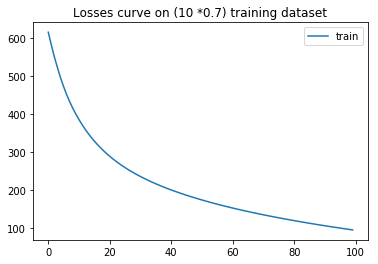

In [17]:
plt.plot(train_loss, label = 'train')
plt.title('Losses curve on (10 *0.7) training dataset')
plt.legend()
plt.show()

## classic AlexNet

### classicAlex: model

In [ ]:
class classicAlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(classicAlexNet, self).__init__()
        ###
        ### Changed 3 to 4 to fit our data dimension sieze
        ###
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x


def alexnet(pretrained=False, progress=True, **kwargs):
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = classicAlexNet(**kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['alexnet'],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


# Playground: before everything

### Load in data from h5py

In [ ]:
data_path = "TCIR-ALL_2017.h5"

# load "info" as pandas dataframe
data_info = pd.read_hdf(data_path, key="info", mode='r')

# load "matrix" as numpy ndarray, this could take longer times
with h5py.File(data_path, 'r') as hf:
    data_matrix = hf['matrix'][:]

### A sketch of label matrix
Vmax is wind speed, MSLP is minimum sea level pressure, R35_4qAVG is radius.

In [ ]:
data_info

### Several visualizations

In [ ]:
plt.plot(data_info.loc[data_info['ID'] == '201733W']['Vmax'])
plt.show()

In [ ]:
plt.imshow(data_matrix[0,:,:,0], cmap='gray')
plt.show()

In [ ]:
plt.imshow(data_matrix[1,:,:,0], cmap='gray')
plt.show()

In [ ]:
plt.imshow(data_matrix[2,:,:,0], cmap='gray')
plt.show()

In [ ]:
plt.imshow(data_matrix[10,:,:,0], cmap='gray')
plt.show()

### Rotate: trial
Problematic: except 90, 180, 270, 360 degrees, rotations of all other degrees have incorrect outputs: whitening

In [ ]:
skimage.transform.rotate(data_matrix[0, :, :, :], 10).shape

In [ ]:
plt.hist(data_matrix[0, :, :, 0].flatten(), 100)
plt.show()

In [ ]:
plt.hist(skimage.transform.rotate(data_matrix[0, :, :, 0], 1, preserve_range=True).flatten(), 100)
plt.show()

In [ ]:
import scipy
plt.hist(scipy.ndimage.rotate(data_matrix[0, :, :, 0], 1).flatten(), 100)
plt.show()

In [ ]:
plt.imshow(data_matrix[0, :, :, 0], cmap='gray')
plt.show()

In [ ]:
plt.imshow(skimage.transform.rotate(data_matrix[0, :, :, 0], 90, preserve_range=True), cmap='gray')
plt.show()

In [ ]:
np.max(data_matrix[0, :, :, 0])

In [ ]:
np.max(skimage.transform.rotate(data_matrix[0, :, :, 0], 10, preserve_range=True))

### Check how many in matrix is nan
Must deal with data outlier as proposed in paper

In [ ]:
np.prod(data_matrix.shape)

In [ ]:
count = 0
for i in range(data_matrix.shape[0]):
    if np.count_nonzero(np.isnan(data_matrix[i, :, :, :])) > 0:
        count += 1
print(count)
print(data_matrix.shape[0])

### Show h5df file content and play with data load step

In [3]:
def h5printR(item, leading = ''):
    for key in item:
        if isinstance(item[key], h5py.Dataset):
            print(leading + key + ': ' + str(item[key].shape))
        else:
            print(leading + key)
            h5printR(item[key], leading + '  ')

# Print structure of a `.h5` file            
def h5print(filename):
    with h5py.File(filename, 'r') as h:
        print(filename)
        h5printR(h, '  ')

In [4]:
file_path = 'TCIR-ALL_2017.h5'
h5_file = h5py.File(file_path)
matrix = h5_file.get('matrix')
target = h5_file.get('info') #/block0_values

In [5]:
list(target['block0_items'])

[b'lon', b'lat', b'Vmax', b'R35_4qAVG', b'MSLP']

In [6]:
h5print('TCIR-ALL_2017.h5')

TCIR-ALL_2017.h5
  info
    axis0: (8,)
    axis1: (4580,)
    block0_items: (5,)
    block0_values: (4580, 5)
    block1_items: (3,)
    block1_values: (1,)
  matrix: (4580, 201, 201, 4)


# Channel average and std
### Test set: 2017 all
### Training + Validation: 2012-2016 two files
#### first 80% training, last 20% validation (should ranom?)
+ ATLN_EPAC_WPAC: $ 47381 \times 0.8 ~= 37900$
+ CPAC_IO_SH: $23118\times 0.8 = 18500$
<br>
+ Mean: [2.66518896e+02 2.34601769e+02 1.80660180e-01 4.49401281e-01]
+ std: [37.01598561 24.43164985  0.43344222  1.42182753]

In [85]:
data_path = "TCIR-ATLN_EPAC_WPAC.h5"

# load "info" as pandas dataframe
data_info = pd.read_hdf(data_path, key="info", mode='r')

# load "matrix" as numpy ndarray, this could take longer times
total = np.zeros((379 + 185,4))
sqd = np.zeros((379 + 185,4))

with h5py.File("TCIR-ATLN_EPAC_WPAC.h5", 'r') as hf:
    data_matrix = hf['matrix'][:]

    for i in range(37900 // 100):
        local = np.nan_to_num(data_matrix[i * 100: (i+1)*100, :, :, :])
        local[local > 1000] = 0
        total[i,:] =  np.sum(local / ((379 + 185) * 100 * 201 * 201), axis = (0, 1, 2))
        sqd[i,:] =  np.sum(local ** 2 / ((379 + 185) * 100 * 201 * 201), axis = (0, 1, 2))
        
with h5py.File("TCIR-CPAC_IO_SH.h5", 'r') as hf:
    data_matrix = hf['matrix'][:]

    for i in range(18500 // 100):
        local = np.nan_to_num(data_matrix[i * 100: (i+1)*100, :, :, :])
        local[local > 1000] = 0
        total[37900 // 100 + i,:] =  np.sum(local / ((379 + 185) * 100 * 201 * 201), axis = (0, 1, 2))
        sqd[37900 // 100 + i,:] =  np.sum(local ** 2 / ((379 + 185) * 100 * 201 * 201), axis = (0, 1, 2))

### Channel average

In [86]:
EX = np.sum(total, axis = 0) #  / ((379 + 185) * 100 * 201 * 201)
print(EX)

[2.66518896e+02 2.34601769e+02 1.80660180e-01 4.49401281e-01]


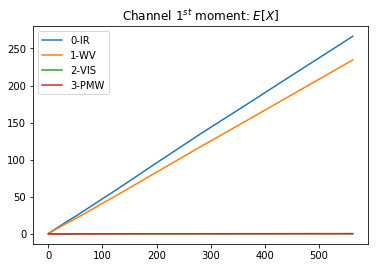

In [87]:
plt.plot(np.cumsum(total, axis = 0))
plt.legend(('0-IR','1-WV','2-VIS','3-PMW'))
plt.title(r'Channel $1^{st}$ moment: $E[X]$')
plt.show()

### Channel std

In [88]:
EX2 = np.sum(sqd, axis = 0)
print(EX2)

[7.24025053e+04 5.56348956e+04 2.20510262e-01 2.22355503e+00]


In [89]:
var = EX2 - EX ** 2
std = var ** 0.5
print(var)
print(std)

[1.37018319e+03 5.96905514e+02 1.87872162e-01 2.02159351e+00]
[37.01598561 24.43164985  0.43344222  1.42182753]


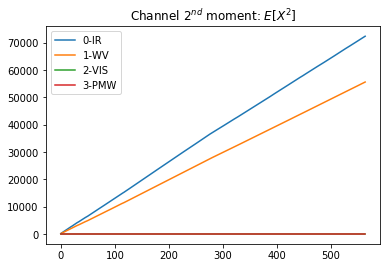

In [90]:
plt.plot(np.cumsum(sqd, axis = 0))
plt.legend(('0-IR','1-WV','2-VIS','3-PMW'))
plt.title(r'Channel $2^{nd}$ moment: $E[X^2]$')
plt.show()